# Propensity Score Matching and Balance Measures with CausalML
This is based on the work in the notebook `dr_learner_with_synthetic_data.ipynb`.

In [71]:
# Note: Some of the content in this notebook is derived from work done by Mike Yung

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install rpy2

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

## Synthetic Data Generation

In [41]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [42]:
y # outcome variable
# X # independent variables
# treatment # w, treatment flag
# tau # individual treatment effect
# b # expected outcome
# e # treatment propensity

array([ 1.77524336,  3.92548881,  2.75758281, ...,  1.61831132,
        2.04593343, -0.67013495])

In [43]:
e.shape
e[:10]

array([0.17697821, 0.81022953, 0.61846972, 0.89226518, 0.87096356,
       0.82667018, 0.890823  , 0.16163058, 0.1       , 0.9       ])

# Create base DF

In [44]:
df = pd.DataFrame(X)
df = df.add_prefix("X")
df["W"] = treatment
df['e'] = e
df

,X0,X1,X2,X3,X4,X5,X6,X7,W,e
0,0.105068,0.539005,0.362262,0.643825,0.418411,0.582381,0.497008,0.360790,0,0.176978
1,0.757392,0.923356,0.104576,0.805266,0.369947,0.123948,0.808361,0.373342,1,0.810230
2,0.511344,0.415077,0.078718,0.819274,0.168583,0.047991,0.626276,0.792687,1,0.618470
3,0.752632,0.466210,0.607964,0.336092,0.930915,0.197989,0.286129,0.275012,1,0.892265
4,0.981774,0.342752,0.906512,0.255387,0.931641,0.720273,0.835399,0.075118,1,0.870964
...,...,...,...,...,...,...,...,...,...,...
9995,0.511366,0.061501,0.304094,0.470371,0.986298,0.550256,0.641056,0.623729,0,0.100000
9996,0.953924,0.880647,0.216329,0.539415,0.435612,0.391881,0.876780,0.023872,1,0.481561
9997,0.642767,0.079430,0.896295,0.551351,0.773968,0.270346,0.125273,0.236030,0,0.159707
9998,0.437681,0.249936,0.992973,0.725424,0.154014,0.881507,0.467242,0.300652,1,0.336940


# Display balance pre/post weighting by inverse probability of treatment (IPTW)

In [45]:
from causalml.metrics.visualize import *

In [59]:
covariates = [col for col in df if col.startswith('X')]
covariates

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

The `plot_ps_diagnostics` function illustrates pre/post weighting by inverse probability of treatment.

Figure(640x480)


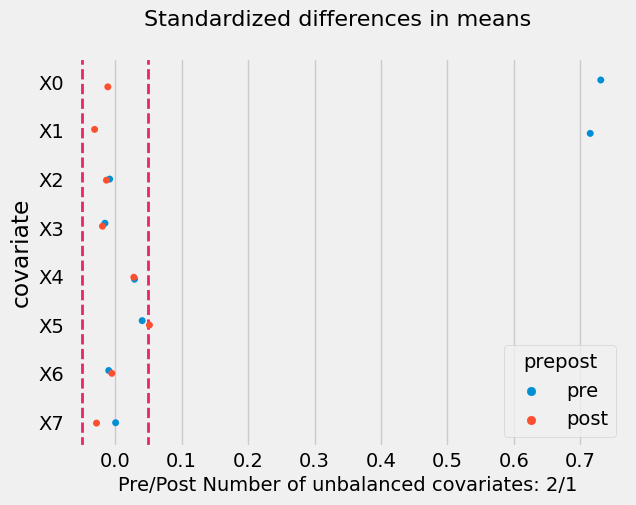

In [67]:
print(plot_ps_diagnostics(df, covariate_col=covariates, treatment_col="W", p_col="e", bal_tol=0.05))

We can also use the `create_table_one` function to view means and standard deviations, in parentheses, of the Control and Treatment groups, as well as the standardized mean differences between the two groups.  The SMD values align with the `pre` values in `plot_ps_diagnostics`.

In [69]:
create_table_one(data=df, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,4837,5163,
X0,0.40 (0.29),0.60 (0.25),0.7309
X1,0.40 (0.30),0.59 (0.25),0.715
X2,0.50 (0.29),0.50 (0.29),-0.0084
X3,0.50 (0.29),0.50 (0.29),-0.0155
X4,0.49 (0.29),0.50 (0.29),0.029
X5,0.50 (0.29),0.51 (0.29),0.0406
X6,0.50 (0.29),0.50 (0.29),-0.0098
X7,0.50 (0.29),0.50 (0.29),0.0006


We can see that for this synthetic data, the X0 and X1 variables are obviously not balanced.

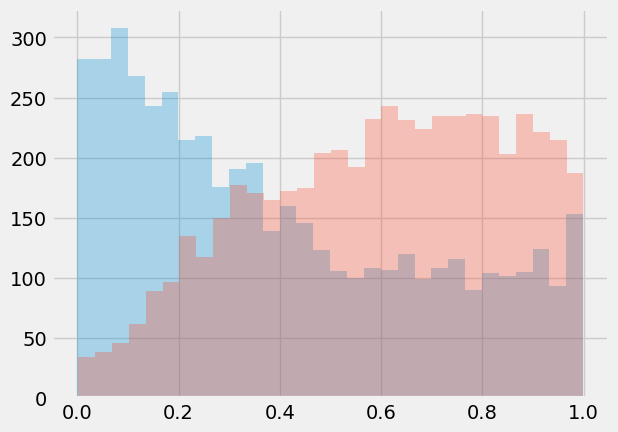

In [76]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X0'], alpha=0.3, bins=30))

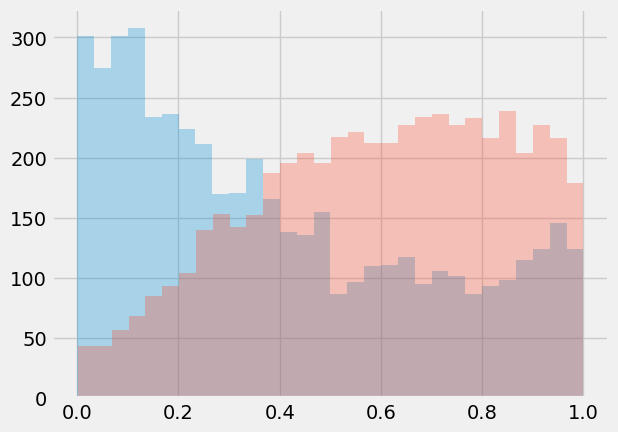

In [77]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X1'], alpha=0.3, bins=30))

From `plot_ps_diagnostics`, `create_table_one`, and via the above histograms, we see that X0 and X1 are clearly unbalanced.

Note that `plot_ps_diagnostics` function shows that we can improve balance through IPTW.  However, we will illustrate below how using matching can also improve balance independent of IPTW.

# Matching

Now let's apply matching to see if we can reduce the SMDs.

The `NearestNeighborMatch` class expects a Pandas DataFrame when `match()` is called, so first we package the existing features data `X` into a dataframe. 

In [96]:
TREATMENT_COL = 'W'
PROPENSITY_COL = 'e'
OUTCOME_COL = 'y'

Next, we instantiate `NearestNeighborMatch` and define `score_cols` to specify the matcher to match on just the propensity variable.

In [97]:
matcher = NearestNeighborMatch()
score_cols = [PROPENSITY_COL]
df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)
create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,2242,2242,
X0,0.51 (0.28),0.50 (0.28),-0.0346
X1,0.50 (0.28),0.49 (0.28),-0.0218
X2,0.50 (0.29),0.50 (0.29),-0.0018
X3,0.51 (0.29),0.50 (0.29),-0.0255
X4,0.50 (0.29),0.50 (0.29),-0.0135
X5,0.49 (0.29),0.51 (0.29),0.0713
X6,0.50 (0.29),0.50 (0.29),0.0151
X7,0.50 (0.29),0.50 (0.29),0.0211


`df_matched` contains the matched subset:

In [98]:
df_matched.shape

(4484, 10)

SMD is the standardized mean difference of the variable between the two classes (Control and Treatment). An SMD value of < 0.1 is typically considered a good balance. Using the synthetically generated data, we achieve good balance for all covariates when matching on the propensity score alone. However, sometimes you may find that matching purely on the propensity variable does not achieve good balance for all the covariates you would like to control for. 

Here, we introduce a noise variable that has some class imbalance and visualize it below.

### 4b. Match Optimization

In [94]:
# currently this has some issues:
#    the MatchOptimizer call fails, until smd_cols=covariates, which I'm not sure of (doesn't include propensity score)
#    the result creates a df that has more rows that the original df

Let's redo the propensity scoring + matching process and take a look at the results.

In [91]:
# opt = MatchOptimizer(treatment_col=TREATMENT_COL,
#                      ps_col=PROPENSITY_COL,
#                      matching_covariates=covariates,
#                      caliper_range=(0.01,1),
#                      smd_cols=covariates,
#                      dev_cols_transformations={PROPENSITY_COL: np.mean},
#                     )
# df_matched = opt.search_best_match(df)

In [93]:
# df_matched  # this has more rows than the original df?

Note that PSM is redundant from a theoretical point of view, but some users report having had good results in practice, as stated in [this issue](https://github.com/uber/causalml/issues/430):

> Propensity score matching is not required for estimating ATEs with meta-learners so long as the covariates that you use block any back-door paths between the treatment and outcome.

> Then again, if the covariates don't block all back-door paths between the treatment and outcome, the matching step will not achieve its intended goal of balancing confounders between treatment and control observations.

> Consequently, using matching with meta-learners is redundant from a theoretical point of view. That said, my understanding is that some users have had good results in practice when combining matching with meta-learners.

We explore if using PSM improves results for this test case and illustrate that in agreement with the theoretical prediction, it does not.  Nevertheless, understanding balance properties can be helpful for diagnosing issues related to covariate distributions.

# Illustrate matching improves covariate balance

We check the matched dataframe's X0 and X1 variables for balance and the histograms seem better aligned.

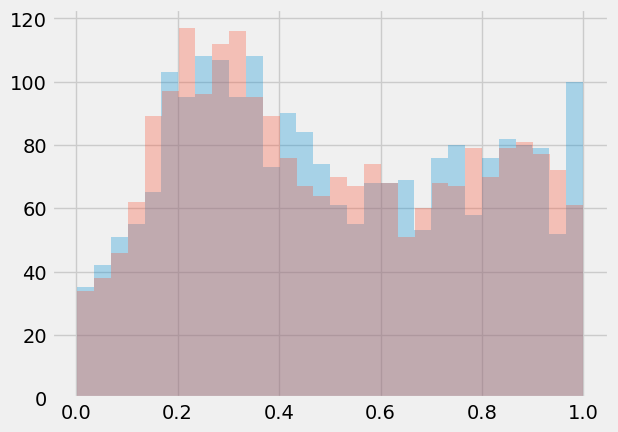

In [99]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X0'], alpha=0.3, bins=30))

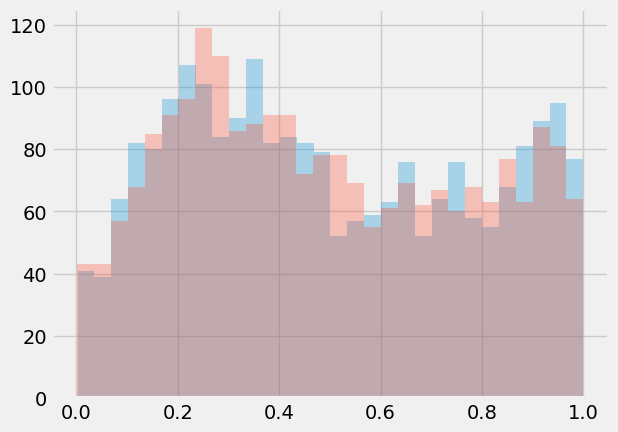

In [100]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X1'], alpha=0.3, bins=30))

Finally, the distribution according to the propensity score also looks balanced.

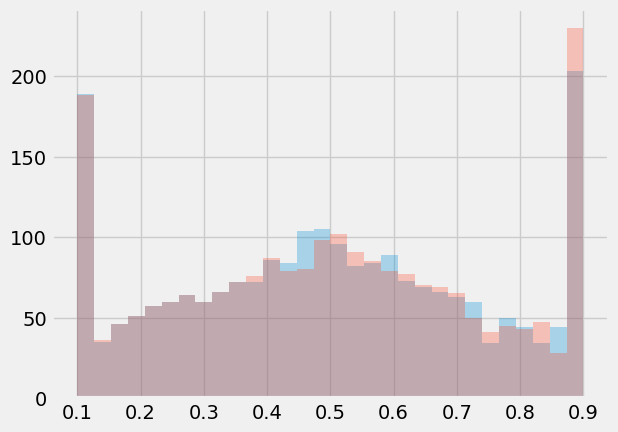

In [102]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['e'], alpha=0.3, bins=30))

## Comparing DR Learner with X Learner

We use a flexible ML estimator to estimate the outcome model but a simple linear regression model to estimate the ITE, since the ITE estimate is often noisy and prone to overfit with a flexible estimator.

In [103]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [104]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

DR Learner outforms X Learner in this dataset. Even with built-in mechanism to counteract the unbalancedness between the treatment and control samples, X Learner still suffers from the regime where the treatment probability is close to 1 in this case.

Text(0.5, 1.0, 'DR Learner')

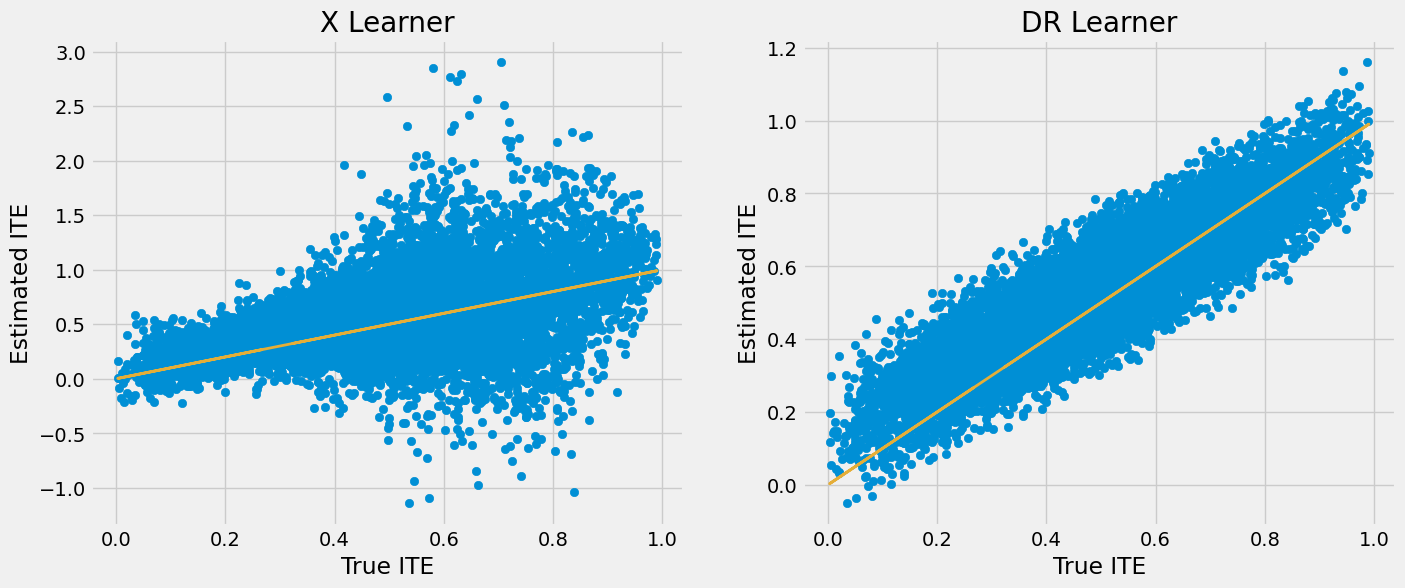

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Re-run learner using matched samples

In [106]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X[df_matched.index.astype(int)],
                               treatment=treatment[df_matched.index.astype(int)],
                               y=y[df_matched.index.astype(int)])

In [107]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X[df_matched.index.astype(int)],
                               treatment=treatment[df_matched.index.astype(int)],
                               y=y[df_matched.index.astype(int)])

In [108]:
cate_x.shape

(4484, 1)

Text(0.5, 1.0, 'DR Learner')

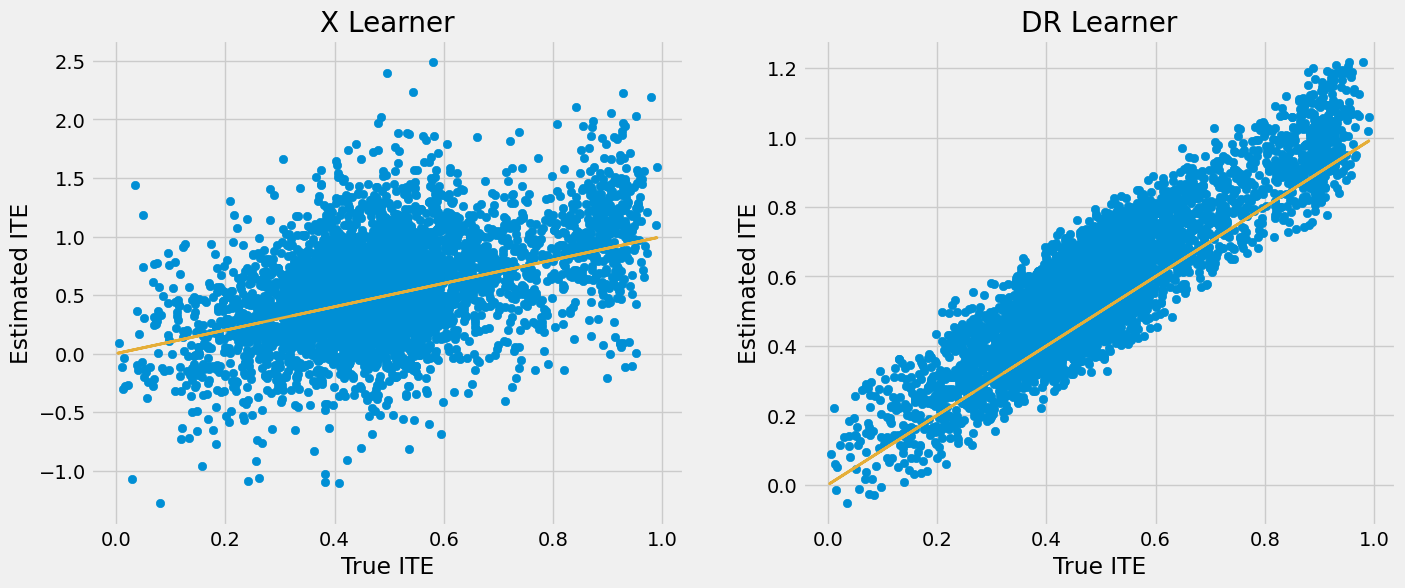

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau[df_matched.index.astype(int)], cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau[df_matched.index.astype(int)], cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Summary

As we can see, the results using the full sample and with a propensity-score-matched subsample do not differ much.  Nevertheless, it can be helpful to understand if there are extreme covariate imbalances in the data and this is done well by the distributional graphs and heuristics provided in Cobalt.